# Notebook B: Find Feasible Bounds for <sup>13</sup>C-MFA using GSM and observed biomass yield
This Jupyter notebook focuses on using Flux Variability Analysis (FVA) to find the bounds of each reaction in a Genome-Scale Metabolic Model (GSM) that are compatible with the measured yields from growth curves. These bounds will be used to constrain the <sup>13</sup>C-Metabolic Flux Analysis (<sup>13</sup>C-MFA) of <i>Y. lipolytica</i> grown on glucose, glycerol, and oleic acid.

### Objective
The objective of this analysis is to integrate <sup>13</sup>C-MFA data with a genome-scale model to explore the metabolic capacity and flexibility under different conditions. This integration is critical for validating the GSM and providing constraints for metabolic simulations.

### Important Functions
`add_gsm_bounds_from_cutoff`<br>
This function uses the biomass yield for a substrate to generate bounds for the MFA reactions using FBA with the GSM.

`get_gsm_df_from_cutoff`<br>
This function performs both parsimonious Flux Balance Analysis (pFBA) and Flux Variability Analysis (FVA) to generate and return a DataFrame detailing reaction IDs, names, full reactions, and calculated flux ranges.

`plot_flux_map`<br>
This function plots flux values or flux bounds using data from columns of the central flux dataframe.

### Structure
For each carbon source the following procedure is used to get bounds for <sup>13</sup>C-MFA reactions
1. Get the average and standard deviation values for the yield coefficient (mmol / g dry cell weight / hr) on the carbon source
2. Calculate the cutoff for the minimum amount of biomass production using two standard deviations below the average yield
3. For each MFA reaction, convert the reaction_ids to a straindesign reaction expression, then run FBA to find the maximum and minimum flux for the reaction given the biomass production constraint
4. Run the FVA with the GSM of generate the flux range for each GSM reaction
5. Plot the MFA bounds that were generated with the GSM

### A note about biomass cutoff calculation
Two standard deviations below the average yield was used to ensure a conservative yet realistic threshold, accounting for potential experimental errors.

### A note about using FBA instead of FVA for MFA reaction bounds



### Load imports

In [1]:
import cobra
import pandas as pd

import sys
source_dir = '../src'
sys.path.append(source_dir)

from gsm_bounds_from_biomass_cutoff.add_gsm_bounds_from_cutoff import add_gsm_bounds_from_cutoff
from gsm_bounds_from_biomass_cutoff.get_gsm_df_from_cutoff import get_gsm_df_from_cutoff
from plotting.plot_flux_map import plot_flux_map

### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x2cdb4ae90
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load <sup>13</sup>C-MFA data

In [4]:
central_rxn_df = pd.read_excel('../data/13c_mfa/Full MFA data 01192024.xlsx', sheet_name='Full MFA Data 01192024')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 46 reactions in the 13C MFA that are mapped to the GSM


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.792,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.517


### Load growth parameters 

In [5]:
# load the growth parameters from a csv
growth_parameters_df = pd.read_csv('../results/growth_parameters/growth_parameters.csv')
growth_parameters_df.set_index('Unnamed: 0', inplace=True)

growth_parameters_df

,glucose,glycerol,oleic_acid
Unnamed: 0,,,
growth_rate,0.266298,0.358041,0.260555
growth_rate_std,0.003048,0.000861,0.012321
yield_coefficient,0.110433,0.058610,0.302000
yield_coefficient_std,0.003913,0.009653,0.070000
substrate_uptake_rate,2.414362,6.266590,0.862765
substrate_uptake_rate_std,0.088704,0.959634,0.204098


# Glucose

### Get biomass cutoff from observed yield coefficient

In [6]:
# Get glucose yield coefficient and standard deviation
glucose_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glucose']
glucose_yield_coefficient_std = growth_parameters_df.loc['yield_coefficient_std', 'glucose']

glucose_biomass_cutoff = glucose_yield_coefficient - 2 * glucose_yield_coefficient_std
print(f'glucose biomass cutoff: {glucose_biomass_cutoff} g biomass per mmol glucose')


glucose biomass cutoff: 0.102607311105205 g biomass per mmol glucose


### Add GSM bounds that are compatible with minimum biomass flux using FVA

In [7]:
central_rxn_df = add_gsm_bounds_from_cutoff(
    model = model,
    central_rxn_df = central_rxn_df,
    substrate = 'Glucose',
    uptake_reaction = 'EX_glc_e',
    biomass_cutoff = 100 * glucose_biomass_cutoff
)

central_rxn_df.head(6)

-EX_glc_e >= 100.0, -EX_glc_e <= 100.0, biomass_glucose >= 10.260731110520501, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose GSM LB,Glucose GSM UB,Glucose_mfa_bound_feasibility
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,fully feasible
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,-28.010193,-0.0,
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,0.0,-0.0,
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.7920,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.5170,-193.771881,92.008809,fully feasible
5,glycolysis/gluconeogensis,R5 net,F6P + ATP <-> FBP,PFK or reverse_FBP,"(-1180, 700)",56.7218,53.3756,59.0811,-20.6531,-20.7135,-19.0518,-144.5891,-148.9667,-128.1481,-355.029195,82.770173,fully feasible


### Generate GSM bounds from the biomass cutoff for glucose

In [8]:
glucose_gsm_df_from_cutoff = get_gsm_df_from_cutoff(
    model=model, 
    central_rxn_df=central_rxn_df,
    substrate='Glucose',
    uptake_reaction = 'EX_glc_e',
    biomass_cutoff = 100 * glucose_biomass_cutoff
)

# save the dataframe to a csv file
glucose_gsm_df_from_cutoff.to_csv('../results/gsm_fluxes/glucose_biomass_bound_gsm_fluxes.csv', index=False)

glucose_gsm_df_from_cutoff.head()


-EX_glc_e >= 100.0, -EX_glc_e <= 100.0, biomass_glucose >= 10.260731110520501, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,reaction_id,reaction_name,full_reaction,Glucose Biomass-Constrained GSM flux,Glucose Biomass-Constrained GSM LB,Glucose Biomass-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,177.514597
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,4.367878,3.461022,103.496827
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],-1.593742,-34.543578,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,11.875006


### Plot flux map with bounds from biomass cutoff

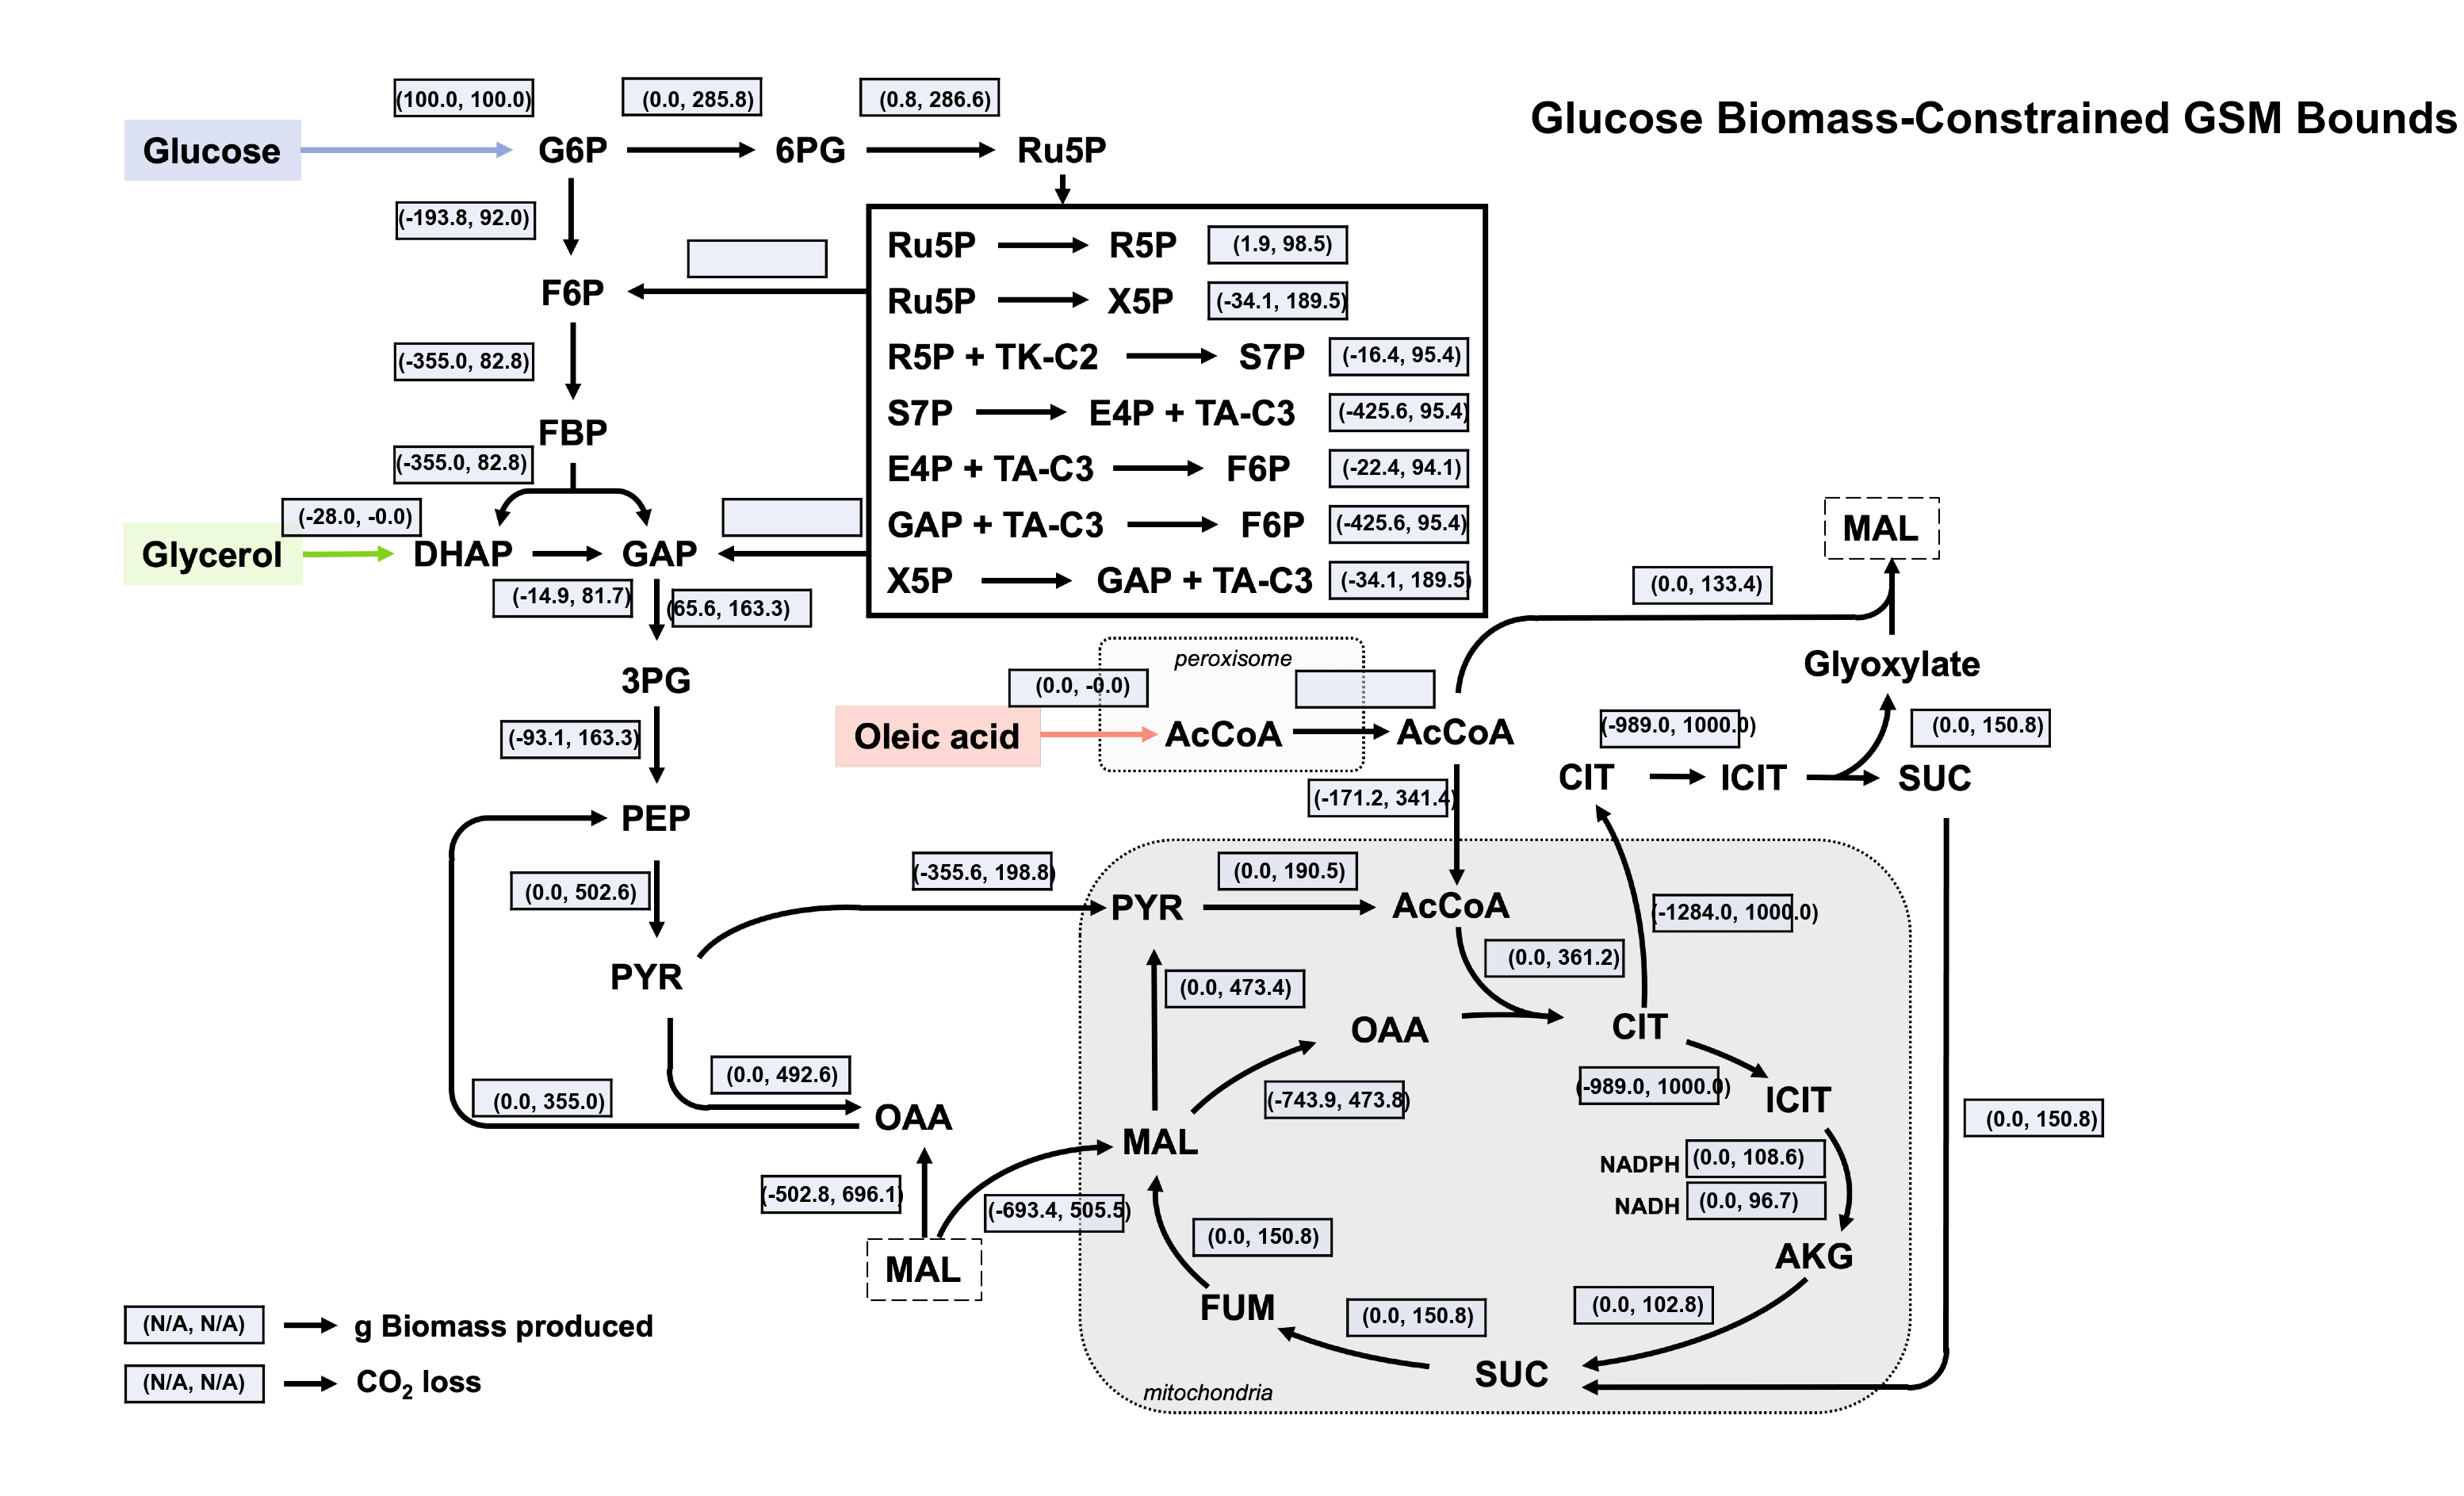

In [9]:
glucose_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Glucose GSM LB', 'Glucose GSM UB'],
    title_string='Glucose Biomass-Constrained GSM Bounds',
    file_name='../figures/Glucose Biomass-Constrained GSM Bounds.png',
)

## Glycerol

### Get biomass cutoff from observed yield coefficient

In [10]:
# Get glycerol yield coefficient
glycerol_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glycerol']
glycerol_yield_coefficient_std = growth_parameters_df.loc['yield_coefficient_std', 'glycerol']

glycerol_biomass_cutoff = glycerol_yield_coefficient - 2 * glycerol_yield_coefficient_std
print(f'glycerol biomass cutoff: {glycerol_biomass_cutoff} g biomass per mmol glycerol')


glycerol biomass cutoff: 0.039303800604366904 g biomass per mmol glycerol


### Add GSM bounds that are compatible with minimum biomass flux using FVA

In [11]:
central_rxn_df = add_gsm_bounds_from_cutoff(
    model = model,
    central_rxn_df = central_rxn_df,
    substrate = 'Glycerol',
    uptake_reaction = 'EX_glyc_e',
    biomass_cutoff = 100 * glycerol_biomass_cutoff
)

central_rxn_df.head(6)

-EX_glyc_e >= 100.0, -EX_glyc_e <= 100.0, biomass_glucose >= 3.9303800604366903, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose GSM LB,Glucose GSM UB,Glucose_mfa_bound_feasibility,Glycerol GSM LB,Glycerol GSM UB,Glycerol_mfa_bound_feasibility
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,fully feasible,0.0,-0.0,
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,-28.010193,-0.0,,100.0,100.0,fully feasible
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,0.0,-0.0,,0.0,-0.0,
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.7920,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.5170,-193.771881,92.008809,fully feasible,-96.832349,-3.061031,fully feasible
5,glycolysis/gluconeogensis,R5 net,F6P + ATP <-> FBP,PFK or reverse_FBP,"(-1180, 700)",56.7218,53.3756,59.0811,-20.6531,-20.7135,-19.0518,-144.5891,-148.9667,-128.1481,-355.029195,82.770173,fully feasible,-177.118595,-6.599897,fully feasible


### Generate GSM bounds from the biomass cutoff for glycerol

In [12]:
glycerol_gsm_df_from_cutoff = get_gsm_df_from_cutoff(
    model=model, 
    central_rxn_df=central_rxn_df,
    substrate='Glycerol',
    uptake_reaction = 'EX_glyc_e',
    biomass_cutoff = 100 * glycerol_biomass_cutoff
)

# save the dataframe to a csv file
glycerol_gsm_df_from_cutoff.to_csv('../results/gsm_fluxes/glycerol_biomass_bound_gsm_fluxes.csv', index=False)

glycerol_gsm_df_from_cutoff.head()

-EX_glyc_e >= 100.0, -EX_glyc_e <= 100.0, biomass_glucose >= 3.9303800604366903, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,reaction_id,reaction_name,full_reaction,Glycerol Biomass-Constrained GSM flux,Glycerol Biomass-Constrained GSM LB,Glycerol Biomass-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,82.709275
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,1.783335,1.325747,45.437360
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.000000,-15.199105,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,5.384212


### Plot flux map with bounds from biomass cutoff

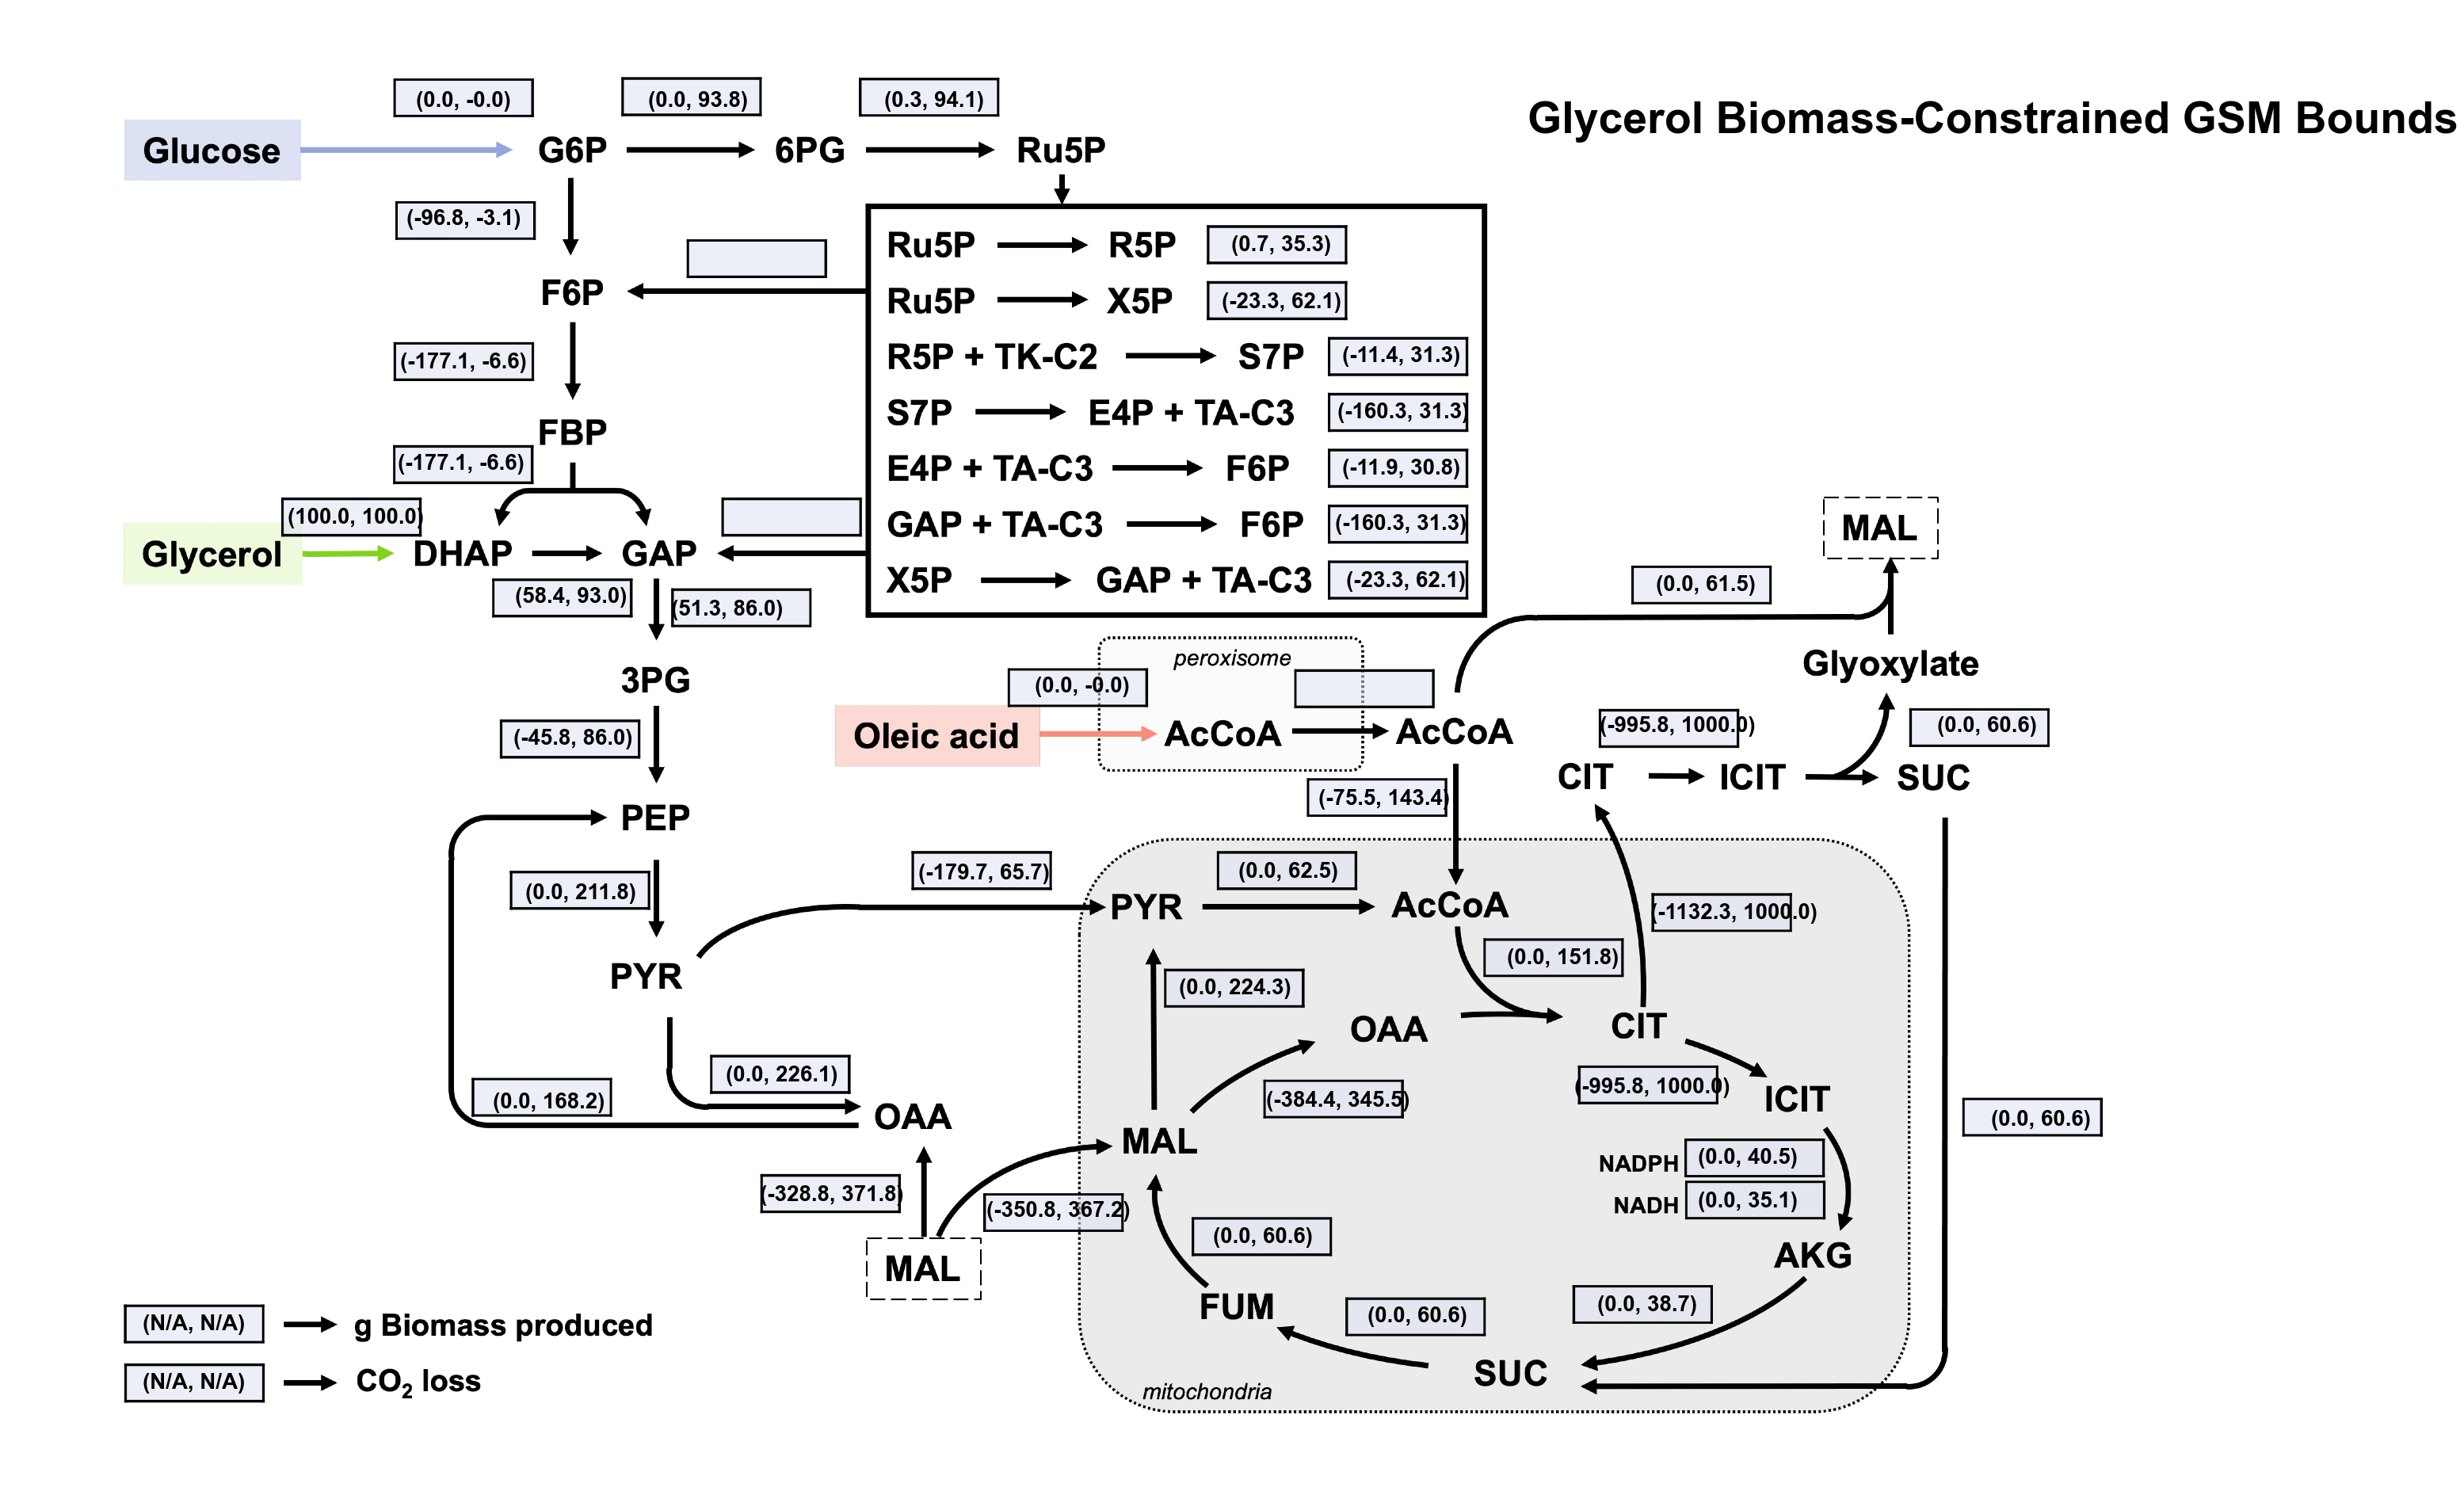

In [13]:
glycerol_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Glycerol GSM LB', 'Glycerol GSM UB'],
    title_string='Glycerol Biomass-Constrained GSM Bounds',
    file_name='../figures/Glycerol Biomass-Constrained GSM Bounds.png',
)

# Oleic Acid

### Get biomass cutoff from observed yield coefficient

In [14]:
# Get oleic_acid yield coefficient
oleic_acid_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'oleic_acid']
oleic_acid_yield_coefficient_std = growth_parameters_df.loc['yield_coefficient_std', 'oleic_acid']

oleic_acid_biomass_cutoff = oleic_acid_yield_coefficient - 2 * oleic_acid_yield_coefficient_std
print(f'oleic_acid biomass cutoff: {oleic_acid_biomass_cutoff} g biomass per mmol oleic_acid')


oleic_acid biomass cutoff: 0.16199999999999998 g biomass per mmol oleic_acid


### Add GSM bounds that are compatible with minimum biomass flux using FVA

In [15]:
central_rxn_df = add_gsm_bounds_from_cutoff(
    model = model,
    central_rxn_df = central_rxn_df,
    substrate = 'Oleic Acid',
    uptake_reaction = 'EX_ocdcea_e',
    biomass_cutoff = 10 * oleic_acid_biomass_cutoff
)

central_rxn_df.head()

-EX_ocdcea_e >= 10.0, -EX_ocdcea_e <= 10.0, biomass_glucose = 0, biomass_oil >= 1.6199999999999997, biomass_C = 0, biomass_N = 0


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,...,Oleic Acid MFA UB,Glucose GSM LB,Glucose GSM UB,Glucose_mfa_bound_feasibility,Glycerol GSM LB,Glycerol GSM UB,Glycerol_mfa_bound_feasibility,Oleic Acid GSM LB,Oleic Acid GSM UB,Oleic Acid_mfa_bound_feasibility
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.000,100.0000,NaN,NaN,...,NaN,100.0,100.0,fully feasible,0.0,-0.0,,0.0,-0.0,
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,...,NaN,-28.010193,-0.0,,100.0,100.0,fully feasible,-196.055208,-0.0,
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,...,NaN,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,...,100.000,0.0,-0.0,,0.0,-0.0,,100.0,100.0,fully feasible
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.792,23.5403,-41.3947,-41.5761,...,-256.517,-193.771881,92.008809,fully feasible,-96.832349,-3.061031,fully feasible,-850.423775,-14.02116,fully feasible


### Generate GSM bounds from the biomass cutoff for oleic acid

In [16]:
oleic_acid_gsm_df_from_cutoff = get_gsm_df_from_cutoff(
    model=model, 
    central_rxn_df=central_rxn_df,
    substrate='Oleic Acid',
    uptake_reaction = 'EX_ocdcea_e',
    biomass_cutoff = 10 * oleic_acid_biomass_cutoff
)

# save the dataframe to a csv file
oleic_acid_gsm_df_from_cutoff.to_csv('../results/gsm_fluxes/oleic_acid_biomass_bound_gsm_fluxes.csv', index=False)

oleic_acid_gsm_df_from_cutoff.head()

-EX_ocdcea_e >= 10.0, -EX_ocdcea_e <= 10.0, biomass_glucose = 0, biomass_oil >= 1.6199999999999997, biomass_C = 0, biomass_N = 0


,reaction_id,reaction_name,full_reaction,Oleic Acid Biomass-Constrained GSM flux,Oleic Acid Biomass-Constrained GSM LB,Oleic Acid Biomass-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,1467.755846
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,7.373489,3.185378,784.858646
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.000000,-203.439156,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,83.513625


### Plot flux map with bounds from biomass cutoff

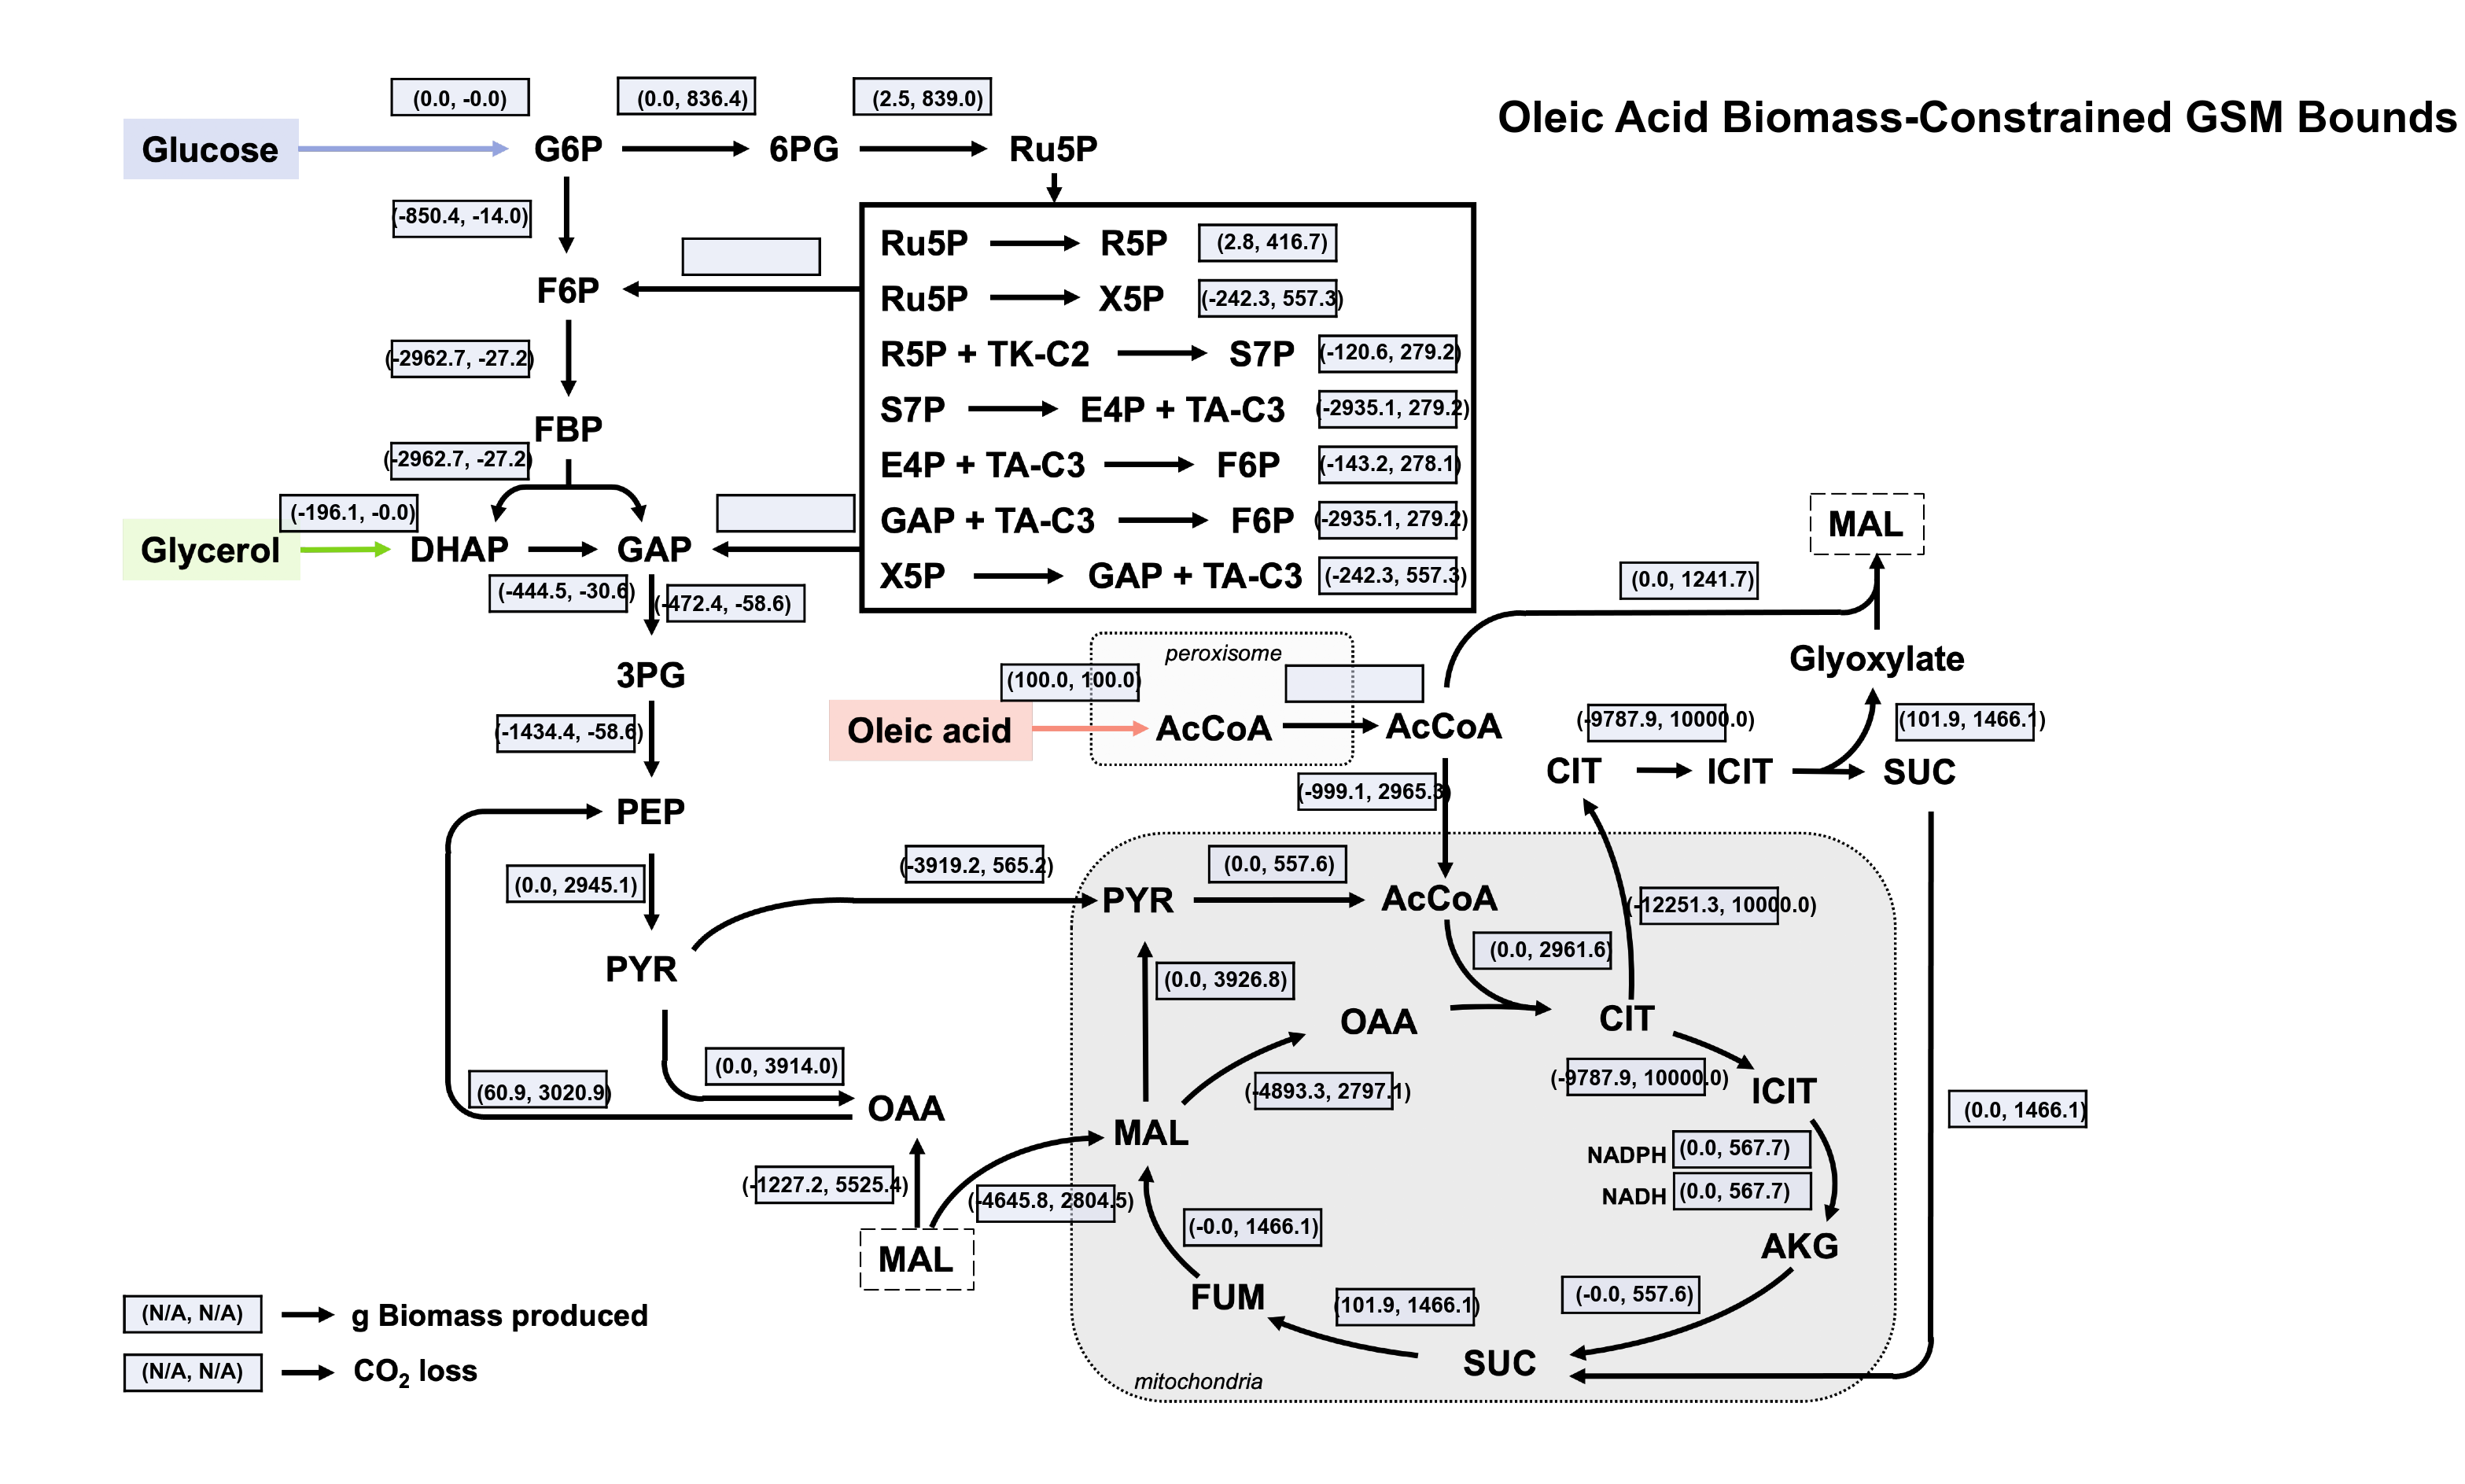

In [17]:
oleic_acid_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Oleic Acid GSM LB', 'Oleic Acid GSM UB'],
    title_string='Oleic Acid Biomass-Constrained GSM Bounds',
    file_name='../figures/Oleic Acid Biomass-Constrained GSM Bounds.png',
)

## Save the GSM bounds so they can be used to constrain the GSM

In [18]:
# save the central_rxn_df
central_rxn_df.to_csv('../results/central_fluxes/mfa_bounds_from_gsm.csv')